In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt


data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo

# Removendo Outliers
for column in ['charges']:
    Q1, Q3 = np.percentile(data[column], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    data_encoded = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
# Aplicando a Obesidade
#data['bmi_obesidade'] = data['bmi'] >= 30
#data['bmi_obesidade_label'] = data['bmi_obesidade'].replace({True: "obese", False: 'not obese'})


# https://www.cancer.org/cancer/risk-prevention/diet-physical-activity/body-weight-and-cancer-risk.html
# IMC entre 25,0 e 29,9 Kg/m2: sobrepeso; 
# IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I; 
# IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II; 
# IMC maior do que 40,0 Kg/m2: obesidade grau III.
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"
    
    

label_encoder = LabelEncoder()
categorical_columns = [ 'smoker', 'weight_condition']
#for col in  categorical_columns:
#    data[col] = label_encoder.fit_transform(data[col])
    
data = pd.get_dummies(data = data, prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')


#preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_columns)])
#base_transformed = preprocessor.fit_transform(data)
#base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
#data = pd.concat([data.drop(columns=categorical_columns), base_transformed_df], axis=1)
data.head()


,age,bmi,children,charges,OHE_yes,OHE_Obese,OHE_Overweight,OHE_Underweight
0,19,27.900,0,16884.92400,1,0,1,0
1,18,33.770,1,1725.55230,0,1,0,0
2,28,33.000,3,4449.46200,0,1,0,0
3,33,22.705,0,21984.47061,0,0,0,0
4,32,28.880,0,3866.85520,0,0,1,0


Modelo:  Ridge(alpha=0.5)
Mean Squared Error (MSE):  32289348.663305555
Mean Absolute Error (MAE):  4101.846826307277
R-squared (R2):  0.7970881901050006


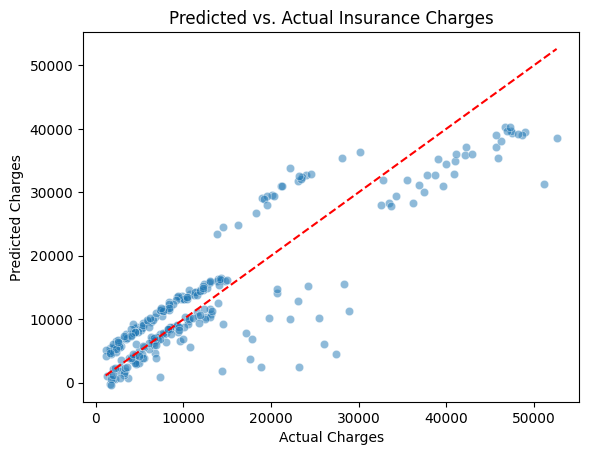

-------------------
Modelo:  Lasso(alpha=0.2)
Mean Squared Error (MSE):  32287550.86484526
Mean Absolute Error (MAE):  4101.639946799631
R-squared (R2):  0.7970994877791411


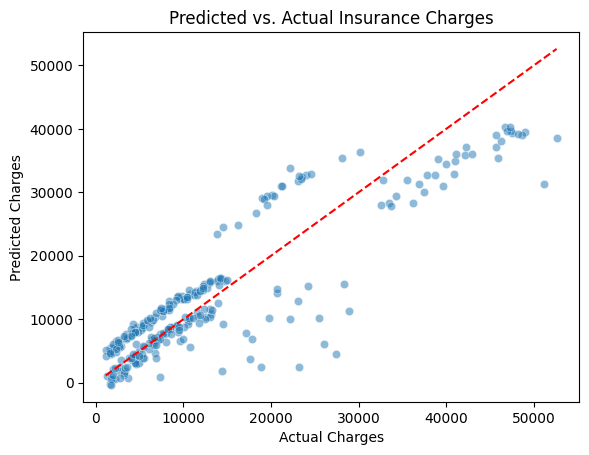

-------------------
Modelo:  LinearRegression()
Mean Squared Error (MSE):  32288223.845232166
Mean Absolute Error (MAE):  4101.795298155491
R-squared (R2):  0.7970952586548639


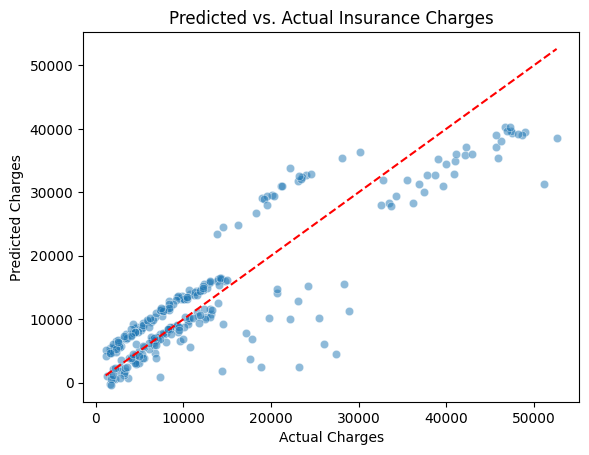

-------------------
Modelo:  DecisionTreeRegressor()
Mean Squared Error (MSE):  55573488.07680664
Mean Absolute Error (MAE):  3669.0167401455224
R-squared (R2):  0.6507666609993306


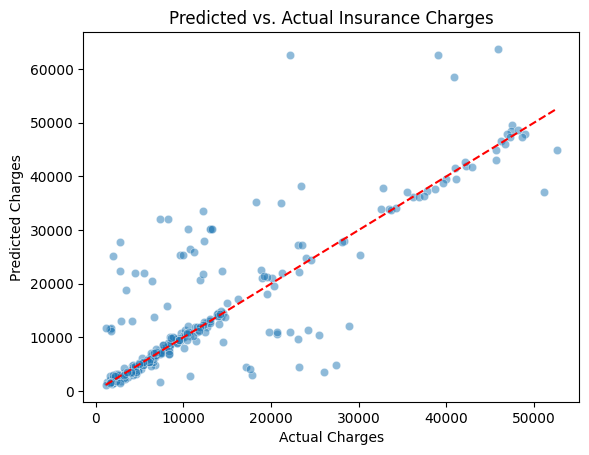

-------------------
Modelo:  RandomForestRegressor(criterion='friedman_mse', n_estimators=200, n_jobs=-1,
                      random_state=1)
Mean Squared Error (MSE):  22158481.93386503
Mean Absolute Error (MAE):  2699.9461353797183
R-squared (R2):  0.8607522957303931


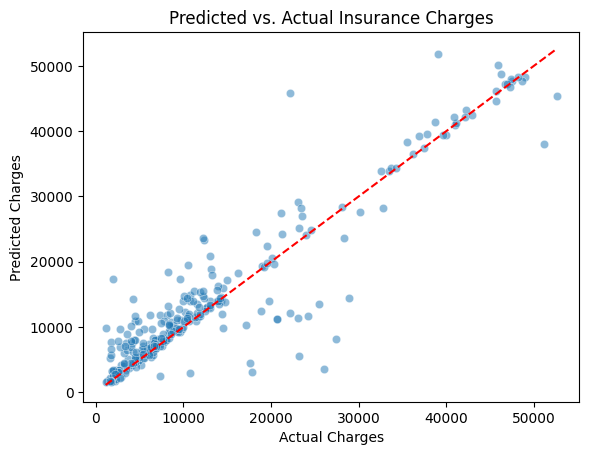

-------------------
Modelo:  KNeighborsRegressor(n_neighbors=20)
Mean Squared Error (MSE):  17163203.419813845
Mean Absolute Error (MAE):  2483.47850375
R-squared (R2):  0.8921434834184746


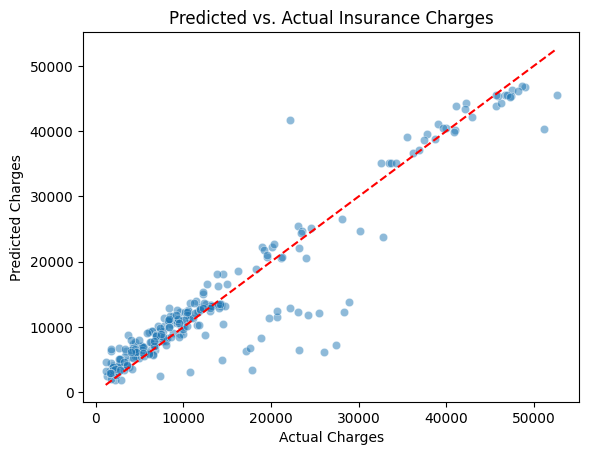

-------------------


In [41]:

X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


scaler = StandardScaler()
scaler.fit(X_train)
x_train_escalonado = scaler.transform(X_train)
x_test_escalonado = scaler.transform(X_test)


# Selecionando alguns modelos e verificando o desempenho
models = [
    Ridge(alpha=0.5),
    Lasso(alpha=0.2, fit_intercept=True, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic'),
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=200, criterion = 'friedman_mse',
                              random_state = 1,
                              n_jobs = -1),
    KNeighborsRegressor(n_neighbors=20)
]

for model in models:
    model.fit(x_train_escalonado, y_train)
    y_pred = model.predict(x_test_escalonado)
    residuals = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Modelo: ", model)
    print('Mean Squared Error (MSE): ', mse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared (R2): ', r2)
    
    # Criando um DataFrame para armazenar os valores reais e previstos
    results = pd.DataFrame({
        "Actual Charges": y_test,
        "Predicted Charges": y_pred
    })
    
    sns.scatterplot(data=results, x="Actual Charges", y="Predicted Charges", alpha=0.5)
    plt.plot(
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        color='red',
        linestyle='--'
    )
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted vs. Actual Insurance Charges")
    plt.show()
    print('-------------------')
    


